In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys

import eggplant as eg


In [24]:
img_size = 32
img = np.zeros((img_size,img_size))

In [25]:
def take_step(xy):
    x = np.random.choice([-1,0,1])
    y = np.random.choice([-1,0,1])
    for k,s in enumerate([x,y]):
        if xy[k] + s < img_size and xy[k] + s >= 0:
            xy[k] = xy[k] + s
    return xy

In [48]:
n_steps = int(1e4)
pos = np.random.uniform(0,img_size,size=2).astype(int)
img[pos[0],pos[1]] = 1
for step in range(n_steps):
    pos = take_step(pos)
    img[pos[0],pos[1]] += 1
    

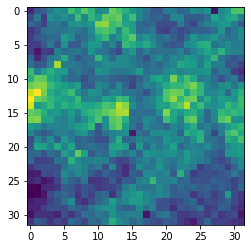

In [49]:
im = plt.imshow(img)
plt.colorbar
plt.show()

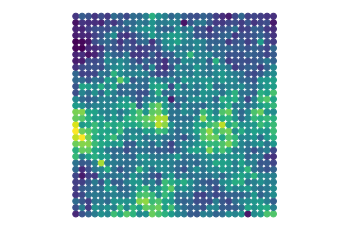

In [199]:
xx = np.arange(-img_size/2,img_size/2)
xx,yy = np.meshgrid(xx,xx)
crd = np.hstack((xx.flatten()[:,np.newaxis],yy.flatten()[:,np.newaxis]))
vals = img.flatten()
plt.scatter(crd[:,0],crd[:,1],c = vals)
plt.axis("equal")
plt.axis("off")
plt.show()

In [287]:
n_max_lmks = 50
n_lmks = np.linspace(3,n_max_lmks-1,10).astype(int)
lmk_idx = np.random.choice(np.arange(vals.shape[0]),size =n_max_lmks,replace =False).astype(int)
lmk = crd[lmk_idx,:]

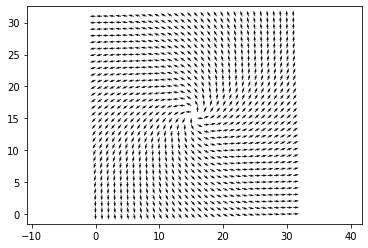

In [410]:
plt.quiver(u,v)
plt.axis("equal")
plt.show()

(-20.66126983722081, 19.66126983722081, -20.66126983722081, 19.66126983722081)

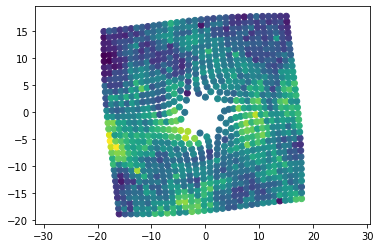

In [447]:
h = 2
x = np.linspace(-h,h,32)
y = np.linspace(-h,h,32)
x,y = np.meshgrid(x,y)

u = (-y + x)/np.sqrt(x**2 + y**2) * 2
v = (x + y)/np.sqrt(x**2 + y**2) * 2


new_xx = xx.flatten() + u.flatten()
new_yy = yy.flatten() + v.flatten()

new_crd = np.hstack((new_xx[:,np.newaxis],new_yy[:,np.newaxis]))
new_lmk = new_crd[lmk_idx,:]
plt.scatter(new_crd[:,0],new_crd[:,1],c  = vals)
plt.axis("equal")

In [458]:
new_vals = griddata(new_crd,vals,(xx,yy),method = "nearest")
new_vals = new_vals.flatten()

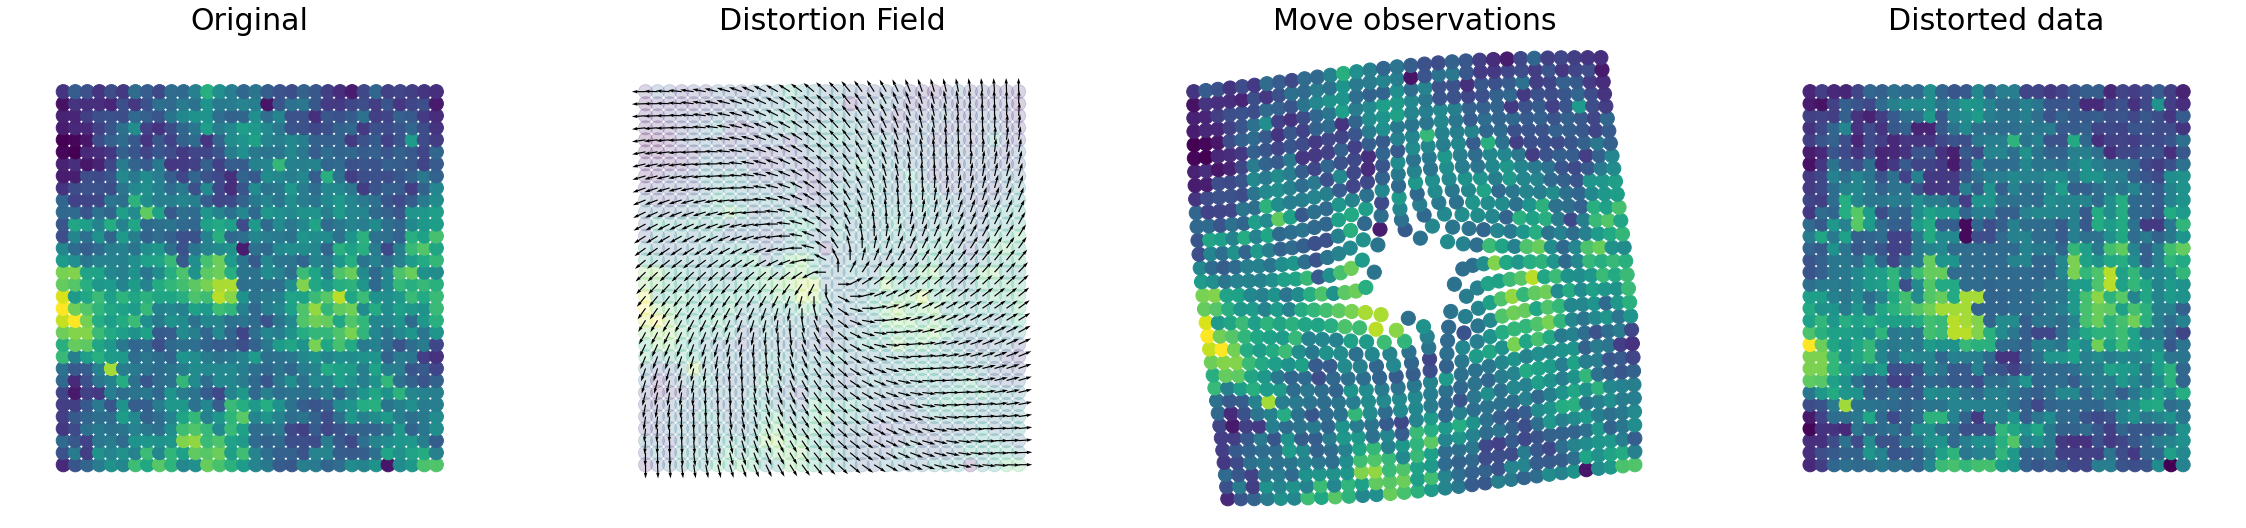

In [467]:
fz = 30

fig,ax = plt.subplots(1,4,sharex=True,sharey=True,figsize = (40,10))

ax[0].scatter(crd[:,0],crd[:,1],c = vals,s=200)
ax[1].scatter(crd[:,0],crd[:,1],c = vals,s=200,alpha = 0.2)
ax[1].quiver(xx,yy,u,v,scale =100)
ax[2].scatter(new_crd[:,0],new_crd[:,1],c = vals,s=200)
ax[3].scatter(crd[:,0],crd[:,1],c = new_vals,s=200)

ax[0].set_title("Original",fontsize=fz)
ax[1].set_title("Distortion Field",fontsize=fz)
ax[2].set_title("Move observations",fontsize=fz)
ax[3].set_title("Distorted data",fontsize=fz)

for aa in ax:
    aa.set_aspect("equal")
    aa.axis("off")


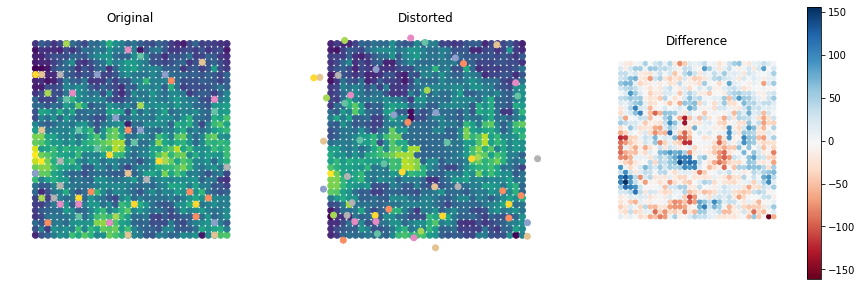

In [446]:
from scipy.interpolate import griddata

colors = np.array([plt.cm.Set2(k % plt.cm.Set2.N) for k in range(n_max_lmks)])

fig,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize = (15,5))
ax[0].scatter(crd[:,0],crd[:,1],c = vals,s=40)
ax[0].scatter(lmk[:,0],lmk[:,1],c = colors)
ax[0].set_title("Original")
ax[1].scatter(crd[:,0],crd[:,1],c = new_vals,s=40)
ax[1].scatter(new_lmk[:,0],new_lmk[:,1],c = colors)
ax[1].set_title("Distorted")
sct = ax[2].scatter(crd[:,0],
                    crd[:,1],
                    c = new_vals - vals,s=20,cmap = plt.cm.RdBu)
ax[2].set_title("Difference")
clb = fig.colorbar(sct,ax = ax[2])
for aa in ax:
    aa.set_aspect("equal")
    aa.axis("off")

plt.show()

In [412]:
X = np.hstack((vals[:,np.newaxis],new_vals[:,np.newaxis]))
var = pd.DataFrame(["original","distorted"],
                   index = ["original","distorted"],
                   columns = ["values"],
                  )
obs_index = [f"Location_{k}" for k in range(vals.shape[0])]
obs = pd.DataFrame(obs_index,
                   index = obs_index,
                   columns = ["location"],
                  )
adata = ad.AnnData(X,
                   var = var,
                   obs = obs,
                  )

adata.obsm["spatial"] = crd

adata

AnnData object with n_obs × n_vars = 1024 × 2
    obs: 'location'
    var: 'values'
    obsm: 'spatial'

In [413]:
def rmse(x,y):
    return np.mean((x - y)**2)

In [414]:
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [415]:
import morphops as mops

In [419]:
n_reps = 3
columns = [f"Rep_{k}" for k in range(n_reps)]
index = n_lmks

egg_res_df = np.zeros((len(index),len(columns)))
tps_res_df = np.zeros((len(index),len(columns)))
true_X = adata.X[:,0].flatten()

for k,n_l in enumerate(n_lmks):
    for ii in range(n_reps):
        sel_lmk = np.random.choice(n_max_lmks,replace = False,size = n_l)
        ref = eg.m.Reference(domain=crd,
                             landmarks = lmk[sel_lmk,:],
                            )
        
        _adata = adata[:,1]
        _adata.uns["curated_landmarks"] = new_lmk[sel_lmk,:]
        
        eg.pp.match_scales(_adata,ref)
        eg.pp.get_landmark_distance(_adata,
                                    reference=ref)
        
        losses = eg.fun.transfer_to_reference(_adata,
                                              ["distorted"],
                                              ref,
                                               n_epochs=1000,
                                            device ="cpu",
                                            verbose = True,
                                            return_losses = True,
                                            return_models =False,
                                           max_cg_iterations = 10000,
                                           )
        
        egg_X = ref.adata.X.flatten()
        egg_res_df[k,ii] = rmse(egg_X,true_X)
        
        tps_crd = mops.tps_warp(new_lmk[sel_lmk,:],lmk[sel_lmk,:],crd)
        tps_X = griddata(tps_crd,adata.X[:,1].flatten(),(xx,yy),method = "nearest").flatten()
        tps_res_df[k,ii] = rmse(tps_X,true_X)
        
        
tps_res_df = pd.DataFrame(tps_res_df,
                         columns = columns,
                          index = index,
                         ) 

egg_res_df = pd.DataFrame(res_df,
                          columns = columns,
                          index = index,
                         )

Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [00:49<00:00, 20.32it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [00:33<00:00, 30.15it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [00:33<00:00, 29.81it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:30<00:00, 11.04it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:43<00:00,  9.62it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:02<00:00, 15.97it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:11<00:00, 14.03it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:11<00:00, 13.98it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [00:58<00:00, 17.24it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:25<00:00, 11.72it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:14<00:00, 13.49it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:31<00:00, 10.96it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:31<00:00, 10.91it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:30<00:00, 11.01it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [00:40<00:00, 24.50it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [00:59<00:00, 16.69it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [00:45<00:00, 22.19it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:35<00:00, 10.48it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:10<00:00, 14.24it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [00:54<00:00, 18.31it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [00:45<00:00, 21.87it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:21<00:00, 12.24it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [00:59<00:00, 16.91it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:10<00:00, 14.15it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:12<00:00, 13.86it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:27<00:00, 11.37it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [00:41<00:00, 24.13it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [01:03<00:00, 15.64it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [00:41<00:00, 23.97it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|██████████| 1000/1000 [00:46<00:00, 21.29it/s]


In [489]:
import matplotlib
matplotlib.rc('font', serif='Calibri')

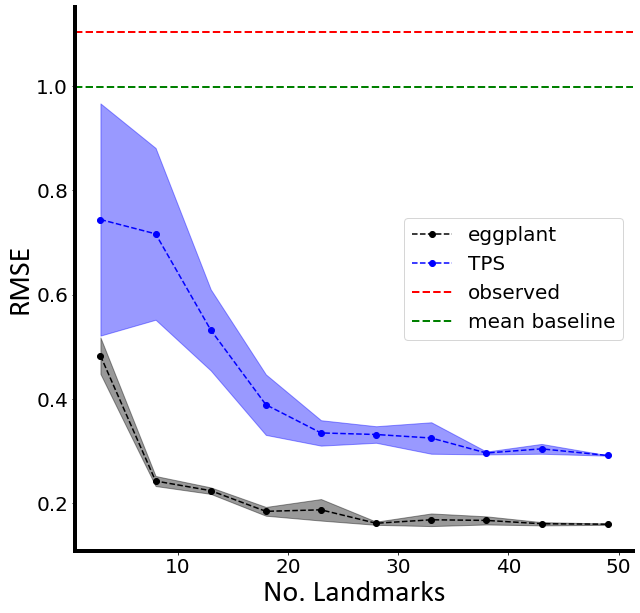

In [491]:
obs_baseline =  rmse(adata.X[:,1].flatten(),adata.X[:,0].flatten())
mean_baseline = rmse(adata.X[:,0].flatten(),np.repeat(np.mean(adata.X[:,0]),len(adata)))

fig,ax = plt.subplots(1,1,figsize = (10,10))

for df,clr,label in zip([egg_res_df,tps_res_df],["black","blue"],["eggplant","TPS"]):
    mean_vals = df.values.mean(axis=1)
    std = df.values.std(axis=1)
    ax.plot(df.index.values,
             mean_vals,
             marker = "o",
             linestyle = "dashed",
             color = clr,
             label  = label,
            )
    se = 2*std / np.sqrt(res_df.shape[1])
    ax.fill_between(df.index.values,
                     mean_vals - se,
                     mean_vals + se,
                     color = clr,
                     alpha = 0.4,
                    )

ax.axhline(y =obs_baseline,color = "red",linewidth = 2,linestyle = "dashed",label = "observed")
ax.axhline(y =mean_baseline,color = "green",linewidth = 2,linestyle = "dashed",label = "mean baseline")

ax.set_ylabel("RMSE",fontsize  =30,family="serif")
ax.set_xlabel("No. Landmarks",fontsize = 30,family="serif")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(4)
ax.spines["bottom"].set_linewidth(4)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=20)

plt.show()